In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

In [3]:
torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
batch_size  = 128
data_path   = "/home/rzhu/data_access/data/mnist"
num_classes = 10

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])
             
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [5]:
con     = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con0.pkl")
adj     = torch.tensor(con["adj_matrix"])
net     = NWN(adj, "sydney")

In [16]:
net                     = NWN(adj, "sydney")
E                       = net.number_of_junctions
net.params["Ron"]       = 1e4
net.params["grow"]      = 5
net.params["decay"]     = 10
net.params["precision"] = True
net.params["collapse"]  = False
net.params["dt"]        = 1e-3
# net.junction_state.L    = torch.rand(E) * 0.3 - 0.15

In [17]:
net.junction_state.updateG()

In [22]:
Gmat = torch.zeros(1024,1024)

Gmat[net.junction_list[:,0], net.junction_list[:,1]] = net.junction_state.G
Gmat[net.junction_list[:,1], net.junction_list[:,0]] = net.junction_state.G


In [25]:
import networkx as nx

In [27]:
Graph = nx.from_numpy_array(np.array(Gmat))

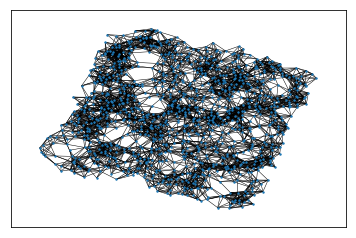

In [32]:
layout = nx.kamada_kawai_layout(Graph)
nx.draw_networkx(Graph, pos = layout, with_labels=False,
                 node_size = 2, 
                 width = 0.5)

In [38]:
abs(torch.linalg.eigvals(Gmat * 1000)).max()

tensor(0.0017)

In [7]:
from snntorch import spikegen

In [8]:
# node_shuffle = torch.randperm(1024)
# electrodes   = node_shuffle[:784+1]
# e_out        = node_shuffle[-100:]
# num_steps    = 25
# data, label  = next(train_batch)

# spk_x   = spikegen.rate(data, 25, 0.5).swapaxes(0,1)
# readout = torch.zeros(batch_size, num_steps, len(e_out))

# for i in tqdm(range(batch_size)):
#     sample      = spk_x[i]
#     sig_in      = torch.zeros(785)
#     for t in range(num_steps):
#         # sig_in[:-1] = sample[t].reshape(-1)
#         sig_in[:-1] = data[i,0].reshape(-1) * 2
#         net.sim(sig_in.reshape(1,-1), electrodes)
#         readout[i,t,:] = net.V[e_out]

In [9]:
def run_batch(net, node_shuffle, 
              batch_data):
    electrodes   = node_shuffle[:784+1]
    e_out        = node_shuffle[-100:]
    num_steps    = 25
    batch_size   = batch_data.shape[0]

    # spk_x   = spikegen.rate(data, 25, 0.5).swapaxes(0,1)
    readout = torch.zeros(batch_size, num_steps, len(e_out))

    for i in tqdm(range(batch_size)):
        # sample      = spk_x[i]
        sig_in      = torch.zeros(785)
        for t in range(num_steps):
            # sig_in[:-1] = sample[t].reshape(-1)
            sig_in[:-1] = batch_data[i,0].reshape(-1) * 2
            net.sim(sig_in.reshape(1,-1), electrodes)
            readout[i,t,:] = net.V[e_out]

    return readout

In [2]:
import dask
from dask.distributed import Client, LocalCluster, progress

In [11]:
cluster = LocalCluster(
                    n_workers = 2,
                    # processes = False,
                    threads_per_worker = 1,
                    scheduler_port = 12121,
                    dashboard_address = 'localhost:11113',
                    )

client = Client(cluster)
client

2023-04-06 00:44:51,009:INFO:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-04-06 00:44:51,009:INFO:NumExpr defaulting to 8 threads.


Client Scheduler: tcp://127.0.0.1:12121 Dashboard: http://127.0.0.1:11113/status,Cluster Workers: 2 Cores: 2 Memory: 33.60 GB


In [12]:
job_pool   = []
label_pool = []
node_shuffle = torch.randperm(1024)

train_loader = DataLoader(mnist_train, batch_size=batch_size)
train_batch = iter(train_loader)
# data, label = next(train_batch)

for batch_data, batch_label in train_batch:
    eval = dask.delayed(run_batch)(net, node_shuffle, batch_data)
    job_pool.append(eval)   
    label_pool.append(batch_label)

In [13]:
# def play_func(x):
#     from time import sleep
#     sleep(x)
#     return x

# pbar = tqdm(total = 100)
# times = torch.randint(3, (100,))
# finished = 0

# ss = [dask.delayed(play_func)(times[i]) for i in range(100)]
# pp = client.compute(ss)

# while finished > 0:
#     idx_pool = np.arange(100)
#     for i in idx_pool:
#         if pp[i].status[0] == "f":
#             idx_pool.pop(i)
#             finished += 1
#             pbar.update(1)

# cc = client.gather(pp)
# pbar.close()

In [14]:
from_dask = client.compute(job_pool)
collected = client.gather(from_dask)

/home/rzhu/miniconda3/envs/nwn_l2l/lib/python3.7/site-packages/distributed/worker.py:3382: UserWarning: Large object of size 4.81 MB detected in task graph: 
  (<nwnTorch.nwn.NWN object at 0x7f0833916210>, tens ... ., 0., 0.]]]]))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [15]:
# node_shuffle = torch.randperm(1024)
# aa = run_batch(net, node_shuffle, data)

In [235]:
mem_dict = pkl_load("/home/rzhu/data_access/data/mnist_nwn/train_mem.pkl")

In [236]:
play = mem_dict["mem_x"][:128]

In [237]:
# lhs = readout.reshape(-1,len(e_out))
lhs = aa.reshape(-1,100)
rhs = play.reshape(-1,10)

In [238]:
W, _, _, _ = torch.linalg.lstsq(lhs,rhs)

In [240]:
def best_regress(lhs, rhs, search_min = -15):
    """
    lhs: [n_samples, n_input_features]
    rhs: [n_samples, n_target_features]
    """
    searches = torch.arange(-1, search_min, -1)
    n_search = len(searches) + 1
    results = torch.zeros(n_search)
    # Ws = torch.zeros(n_search, lhs.shape[1], dtype = lhs.dtype)
    Ws = []
    for i in range(n_search):
        if i == 0:
            rcond = None
        else:
            rcond = torch.float_power(10, searches[i-1])

        # Ws[i] = torch.linalg.lstsq(lhs, rhs, rcond = rcond).solution
        temp = torch.linalg.lstsq(lhs, rhs, rcond = rcond).solution
        # predict = temp @ lhs.T
        predict = lhs @ temp
        results[i] = get_MSE(predict, rhs)
        Ws.append(temp)

    best = torch.argmin(results)
    return Ws[best], results[best], -best

In [241]:
W_out,_,_ = best_regress(lhs, rhs)

In [242]:
W_out = torch.linalg.lstsq(lhs, rhs).solution

In [243]:
aaa = lhs.reshape(-1,25,100)

In [244]:
bbb = aaa@W_out

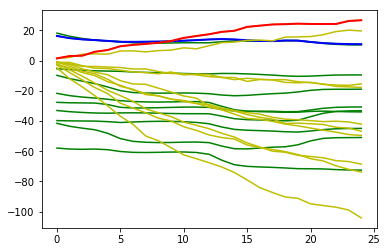

In [247]:
idx = 120
out_max    = bbb[idx].sum(axis = 0).argmax()
target_max = play[idx].sum(axis = 0).argmax()

plt.plot(bbb[idx], c = "g")
plt.plot(bbb[idx][:,out_max], c = "b", lw = 2)


plt.plot(play[idx], c = "y")
plt.plot(play[idx][:,target_max], c = "r", lw = 2)
